In [1]:
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import mysql_conn as mc

%matplotlib inline
sns.set_style("white")

# Time Series

In the last session, we looked at the seller side of olist. We started by getting a feeling for how many sellers there are and how they perform. In this section, we add one of the most crucial dimensions when evlauting metrics: **Time**. 
This allows us to put our metrics in relation to the past, which in turn helps us to judge and thus conclude if we are performing better or worse than in the past.

We start by looking at the number of orders.

## Orders

In [2]:
conn = mc.connect()

Please provide your password········


In [3]:
query = """
SELECT
    DATE(order_purchase_timestamp)  AS date_id,
    COUNT(*)                        AS orders
FROM orders
WHERE order_purchase_timestamp >= '2017-01-01'
    AND order_purchase_timestamp < '2018-09-01'
GROUP BY 1
ORDER BY 1;
"""

daily_orders = pd.read_sql(query, conn)

In [4]:
daily_orders.head()

,date_id,orders
0,2017-01-05,32
1,2017-01-06,4
2,2017-01-07,4
3,2017-01-08,6
4,2017-01-09,5


In [5]:
daily_orders.dtypes

date_id    object
orders      int64
dtype: object

In [6]:
daily_orders["date_id"] = pd.to_datetime(daily_orders["date_id"])

In [7]:
daily_orders.dtypes

date_id    datetime64[ns]
orders              int64
dtype: object

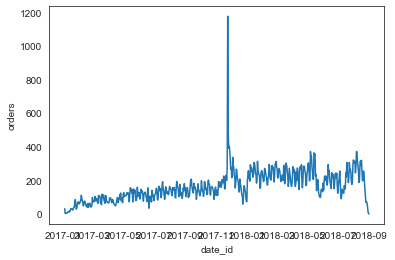

In [8]:
sns.lineplot(data=daily_orders,
             x="date_id",
             y="orders");

Too much detail. Look at weekly data

In [9]:
daily_orders.assign(day_of_week=daily_orders["date_id"].dt.dayofweek)

,date_id,orders,day_of_week
0,2017-01-05,32,3
1,2017-01-06,4,4
2,2017-01-07,4,5
3,2017-01-08,6,6
4,2017-01-09,5,0
...,...,...,...
599,2018-08-27,67,0
600,2018-08-28,44,1
601,2018-08-29,14,2
602,2018-08-30,4,3


In [10]:
weekly_orders = daily_orders.copy()

In [11]:
weekly_orders = weekly_orders.assign(date_id=daily_orders["date_id"] - pd.to_timedelta(daily_orders["date_id"].dt.dayofweek, unit="D"))

In [12]:
weekly_orders = (weekly_orders
                 .groupby("date_id", as_index=False)
                 .agg({"orders": "sum"}))

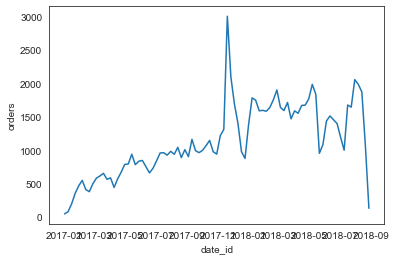

In [13]:
sns.lineplot(data=weekly_orders,
             x="date_id",
             y="orders");

Better. But try monthly data as well.

In [14]:
monthly_orders = daily_orders.copy()

In [15]:
monthly_orders.head()

,date_id,orders
0,2017-01-05,32
1,2017-01-06,4
2,2017-01-07,4
3,2017-01-08,6
4,2017-01-09,5


In [16]:
monthly_orders = monthly_orders.assign(date_id=monthly_orders["date_id"].dt.strftime("%Y-%m-01"))

In [17]:
monthly_orders["date_id"] = pd.to_datetime(monthly_orders["date_id"])

In [18]:
monthly_orders = monthly_orders.groupby("date_id", as_index=False).agg({"orders": "sum"})

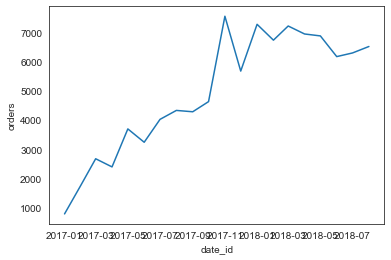

In [19]:
sns.lineplot(data=monthly_orders,
             x="date_id",
             y="orders");

Much better. In this graph, we can see that our number of orders have been increasing throughout 2017. Once 2018 starts, however, the graph suggests that we stopped our growth trajectory. It even suggests that the number of monthly orders started to decline.

An alternative way to plot comparisons over years, is:

Orders for each month, by year:

| year | month | orders |
|------|-------|--------|
| 2017 | 01 | 1356 |
| ... | ... | ... |
| 2018 | 07 | 125092 |

In [20]:
monthly_orders = (monthly_orders
                  .assign(year=monthly_orders["date_id"].dt.year)
                  .assign(month=monthly_orders["date_id"].dt.month))

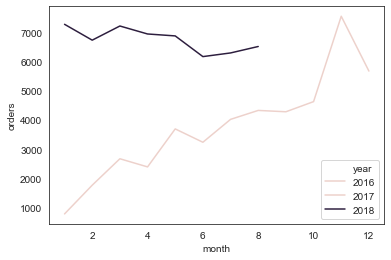

In [21]:
sns.lineplot(data=monthly_orders,
             x="month",
             y="orders",
             hue="year");

This view helps us in spotting multiple relationships. We can clearly see how each month compares to the previous month. It also allows us to remove seasonality. To remove seasonality, we can compare each month with the same month in the previous year.

mom := month over month

yoy := year over year

## Orders, Sellers, Items Sold, Revenue

In [22]:
query_2 = """
SELECT
    YEAR(o.order_purchase_timestamp)    AS year,
    MONTH(o.order_purchase_timestamp)   AS month,
    COUNT(*)                            AS items_sold,
    SUM(oi.price)                       AS revenue,
    COUNT(DISTINCT o.order_id)          AS orders,
    COUNT(DISTINCT
            IF(o.order_status = 'delivered',
                oi.seller_id,
                NULL))                  AS sellers
FROM order_items oi
    INNER JOIN orders o
    ON oi.order_id = o.order_id
WHERE o.order_purchase_timestamp >= '2017-01-01'
    AND o.order_purchase_timestamp < '2018-09-01'
GROUP BY 1,2
ORDER BY 1,2;
"""

monthly_metrics = pd.read_sql(query_2, conn)

In [23]:
monthly_metrics.head()

,year,month,items_sold,revenue,orders,sellers
0,2017,1,955,120312.869803,789,219
1,2017,2,1951,247303.019816,1733,402
2,2017,3,2998,374198.319500,2639,476
3,2017,4,2684,359927.229713,2391,488
4,2017,5,4134,505871.159306,3659,563


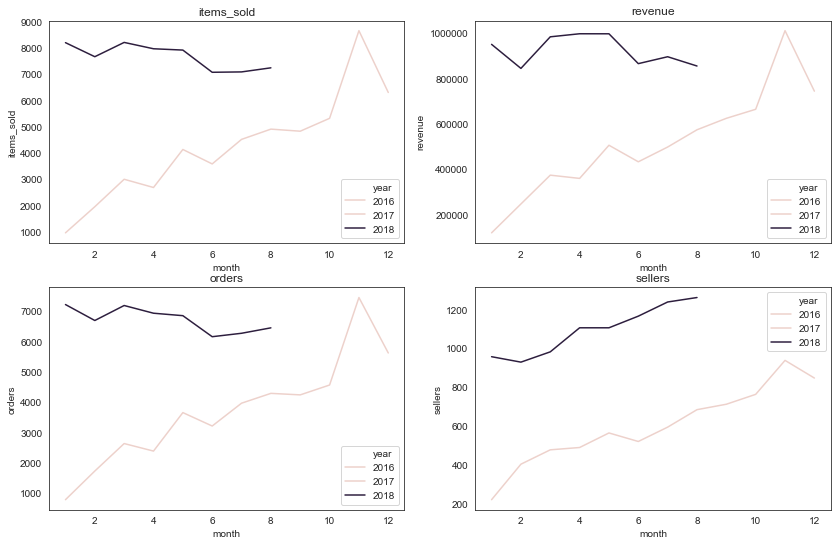

In [24]:
fig, axes = plt.subplots(nrows=2,
                         ncols=2,
                         figsize=(14,9))
metrics = ["items_sold", "revenue", "orders", "sellers"]

i = 0
for ax in axes.flatten():
    sns.lineplot(data=monthly_metrics,
                 x="month",
                 y=metrics[i],
                 hue="year",
                 ax=ax);
    ax.set_title(metrics[i]);
    i += 1

- Orders & Items sold tend to decrease in 2018
- Sellers tend to increase in 2018
- Revenue suggests to remain constant in 2018

### Plot
- Items per order (const)
- Items per seller (down)
- Revenue per Item (up)

In [32]:
monthly_metrics = (monthly_metrics
                   .assign(items_per_order=monthly_metrics["items_sold"] / monthly_metrics["orders"],
                           items_per_seller=monthly_metrics["items_sold"] / monthly_metrics["sellers"],
                           revenue_per_item=monthly_metrics["revenue"] / monthly_metrics["items_sold"]))

In [33]:
monthly_metrics.head()

,year,month,items_sold,revenue,orders,sellers,items_per_order,items_per_seller,revenue_per_item
0,2017,1,955,120312.869803,789,219,1.210393,4.360731,125.982063
1,2017,2,1951,247303.019816,1733,402,1.125793,4.853234,126.757058
2,2017,3,2998,374198.319500,2639,476,1.136036,6.298319,124.815984
3,2017,4,2684,359927.229713,2391,488,1.122543,5.500000,134.101054
4,2017,5,4134,505871.159306,3659,563,1.129817,7.342806,122.368447


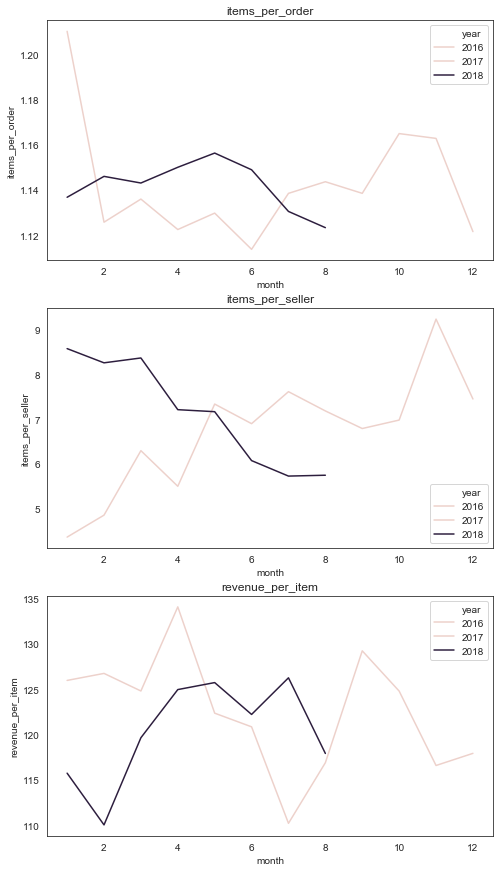

In [34]:
fig, axes = plt.subplots(nrows=3,
                         ncols=1,
                         figsize=(8,15))

rel_metrics = ["items_per_order", "items_per_seller", "revenue_per_item"]

i = 0
for ax in axes:
    sns.lineplot(data=monthly_metrics,
                 x="month",
                 y=rel_metrics[i],
                 hue="year",
                 ax=ax)
    ax.set_title(rel_metrics[i])
    i += 1

It seems like the Orders and Items sold were both declining. We can also see that the average number of items per order has been constant. However, looking at the sellers, it suggests that there are actually more unique sellers, selling less items on average. We can also see that monthly revenue has been mostly constant. Hence, the revenue we generate for each order or item increases over time.

We should be focusing on understanding the decline in orders and items sold.

In the following, we are going to dig a little bit into orders to find insights and actionable recommendations for management, as to whether 1) we should be worried about the decline and 2) if so, what we can do about it. 

## Drill into orders based on customer dimensions

| date_id (month) | customer_state | orders |
|-----------------|----------------|--------|
| 2017-01-01      | SP             | 1356   |

In [35]:
query_3 = """
SELECT
    DATE_FORMAT(o.order_purchase_timestamp, '%Y-%m-01') AS date_id,
    c.customer_state,
    COUNT(*)                                            AS orders
FROM orders o
    JOIN customers c
    ON o.customer_id = c.customer_id
WHERE o.order_purchase_timestamp >= '2017-01-01'
  AND o.order_purchase_timestamp < '2018-09-01'
GROUP BY date_id, c.customer_state;
"""

mthly_order_by_state = pd.read_sql(query_3, conn)

In [36]:
mthly_order_by_state.head()

,date_id,customer_state,orders
0,2017-10-01,SP,1793
1,2018-07-01,BA,250
2,2018-08-01,GO,120
3,2017-11-01,RN,44
4,2018-02-01,SP,2703


In [37]:
mthly_order_by_state.dtypes

date_id           object
customer_state    object
orders             int64
dtype: object

In [ ]:
mthly_order_by_state["date_id"] = pd.to_datetime(mthly_order_by_state["date_id"])

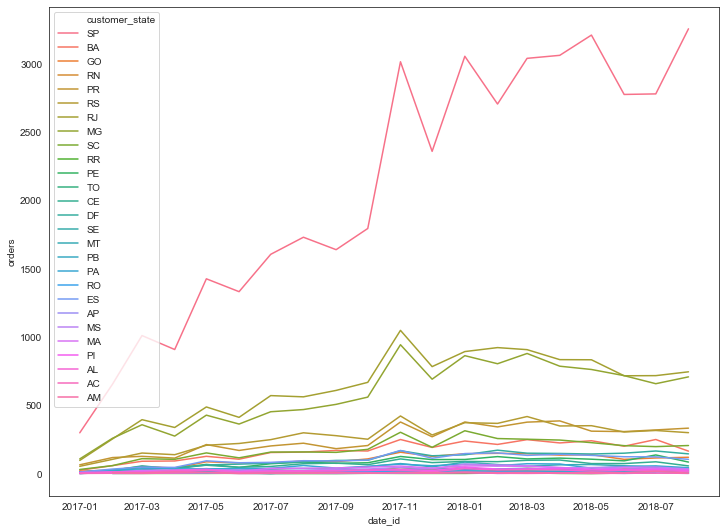

In [42]:
fig, ax = plt.subplots(figsize=(12,9))

sns.lineplot(data=mthly_order_by_state,
             x="date_id",
             y="orders",
             hue="customer_state",
             ax=ax);

Remove detail from smaller states

- 1. Retrieve the top 5 states (based on last month)
- 2. Group all remaining states into one 'Other'

**1. Retrieve the top 5 states (based on last month)**

In [62]:
# get last month
mthly_order_by_state["date_id"].max()

Timestamp('2018-08-01 00:00:00')

In [47]:
# filter df for only values of the last month
top_states = mthly_order_by_state.loc[mthly_order_by_state["date_id"] == mthly_order_by_state["date_id"].max()]
top_states

,date_id,customer_state,orders
2,2018-08-01,GO,120
20,2018-08-01,SP,3253
32,2018-08-01,BA,165
42,2018-08-01,DF,145
60,2018-08-01,CE,57
62,2018-08-01,SC,206
69,2018-08-01,RN,20
91,2018-08-01,MG,708
104,2018-08-01,PR,333
111,2018-08-01,RS,300


In [52]:
top_states = top_states.sort_values("orders", ascending=False).head(5)
top_states

,date_id,customer_state,orders
20,2018-08-01,SP,3253
146,2018-08-01,RJ,745
91,2018-08-01,MG,708
104,2018-08-01,PR,333
111,2018-08-01,RS,300


In [55]:
top_states = top_states["customer_state"].to_list()
top_states

['SP', 'RJ', 'MG', 'PR', 'RS']

In [61]:
# alternatively

(mthly_order_by_state
 .loc[mthly_order_by_state["date_id"] == mthly_order_by_state["date_id"].max()]
 .nlargest(5, "orders")
 ["customer_state"]
 .to_list())

['SP', 'RJ', 'MG', 'PR', 'RS']

**2. Group all remaining states into one 'Other'**

In [66]:
np.where(mthly_order_by_state["customer_state"].isin(top_states), mthly_order_by_state["customer_state"], "Other")

array(['SP', 'Other', 'Other', 'Other', 'SP', 'PR', 'RS', 'RJ', 'RS',
       'SP', 'MG', 'SP', 'SP', 'Other', 'RJ', 'Other', 'SP', 'Other',
       'SP', 'Other', 'SP', 'RJ', 'Other', 'SP', 'Other', 'SP', 'Other',
       'SP', 'Other', 'Other', 'Other', 'Other', 'Other', 'SP', 'Other',
       'RS', 'PR', 'RJ', 'RJ', 'Other', 'SP', 'SP', 'Other', 'RJ', 'MG',
       'MG', 'Other', 'Other', 'SP', 'MG', 'PR', 'Other', 'RS', 'Other',
       'MG', 'RS', 'Other', 'Other', 'MG', 'PR', 'Other', 'SP', 'Other',
       'RS', 'Other', 'MG', 'RJ', 'RJ', 'RS', 'Other', 'Other', 'PR',
       'MG', 'RJ', 'SP', 'PR', 'Other', 'Other', 'RS', 'Other', 'MG',
       'PR', 'Other', 'RS', 'Other', 'Other', 'Other', 'MG', 'Other',
       'Other', 'PR', 'MG', 'MG', 'Other', 'RS', 'RJ', 'RS', 'Other',
       'Other', 'RS', 'Other', 'Other', 'MG', 'PR', 'PR', 'Other',
       'Other', 'Other', 'PR', 'SP', 'SP', 'RS', 'RJ', 'Other', 'Other',
       'Other', 'Other', 'Other', 'RS', 'Other', 'Other', 'PR', 'Other',
  

In [68]:
mthly_order_by_state = mthly_order_by_state.assign(grouped_state=np.where(mthly_order_by_state["customer_state"].isin(top_states),
                                                                          mthly_order_by_state["customer_state"],
                                                                          "Other"))
mthly_order_by_state

,date_id,customer_state,orders,grouped_state
0,2017-10-01,SP,1793,SP
1,2018-07-01,BA,250,Other
2,2018-08-01,GO,120,Other
3,2017-11-01,RN,44,Other
4,2018-02-01,SP,2703,SP
...,...,...,...,...
528,2017-06-01,AM,1,Other
529,2017-02-01,AP,2,Other
530,2017-11-01,RR,2,Other
531,2017-07-01,RR,1,Other


In [69]:
mo_grouped_states = mthly_order_by_state.copy()

In [71]:
mo_grouped_states = (mo_grouped_states
                     .groupby(["date_id", "grouped_state"], as_index=False)
                     .agg({"orders": "sum"}))

In [72]:
mo_grouped_states.head()

,date_id,grouped_state,orders
0,2017-01-01,MG,108
1,2017-01-01,Other,177
2,2017-01-01,PR,65
3,2017-01-01,RJ,97
4,2017-01-01,RS,54


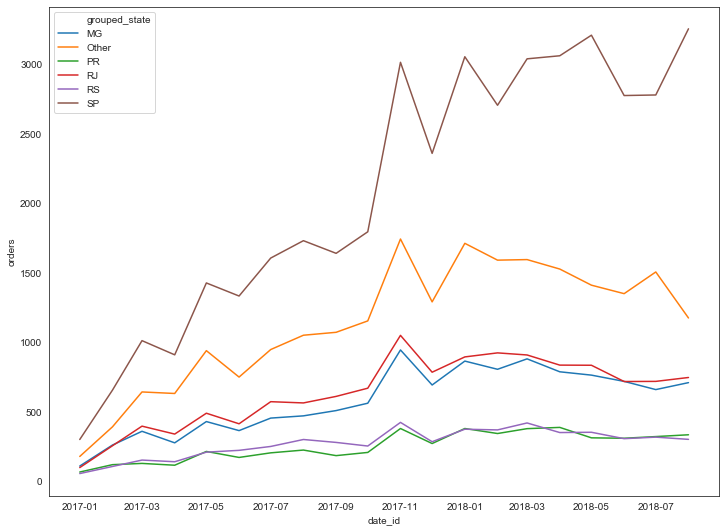

In [73]:
fig, ax = plt.subplots(figsize=(12,9))

sns.lineplot(data=mo_grouped_states,
             x="date_id",
             y="orders",
             hue="grouped_state",
             ax=ax);

The graph suggests that orders placed by customers in Sao Paolo did not decrease as much as in other states. There may be a relationship between orders over time and the time it takes to deliver those orders, since we ship from Sao Paolo. 

## Dig into the relationship between the decline in orders and the waiting time for each state

For each state, compute:
- 1. average number of delivery days (Jan 2018 - Aug 2018)
- 2. relative growth between Aug 2018 and Jan 2018

**1. Get avg. delivery days**

In [74]:
query_4 = """
SELECT
    c.customer_state,
    AVG(DATEDIFF(o.order_delivered_customer_date, o.order_purchase_timestamp)) AS delivery_days
FROM orders o
    JOIN customers c
    ON o.customer_id = c.customer_id
WHERE o.order_purchase_timestamp >= '2018-01-01'
    AND o.order_purchase_timestamp < '2018-09-01'
    AND o.order_status = 'delivered'
    AND o.order_delivered_customer_date IS NOT NULL
GROUP BY c.customer_state;
"""

avg_dd = pd.read_sql(query_4, conn)

In [75]:
avg_dd.head()

,customer_state,delivery_days
0,BA,19.0788
1,GO,15.0803
2,SP,8.2169
3,MG,11.7857
4,RJ,15.6823


**relative growth between Jan 2018 and Aug 2018**

In [81]:
# SP
sp_example = mthly_order_by_state.loc[mthly_order_by_state["customer_state"] == "SP"].sort_values("date_id").copy()

In [82]:
sp_example

,date_id,customer_state,orders,grouped_state
123,2017-01-01,SP,299,SP
110,2017-02-01,SP,654,SP
40,2017-03-01,SP,1010,SP
109,2017-04-01,SP,908,SP
61,2017-05-01,SP,1425,SP
41,2017-06-01,SP,1331,SP
9,2017-07-01,SP,1604,SP
25,2017-08-01,SP,1729,SP
18,2017-09-01,SP,1638,SP
0,2017-10-01,SP,1793,SP


In [80]:
(3253 / 3052) - 1

0.06585845347313235

Sao Paolo grew by 6.6% from Jan to Aug 2018

In [95]:
sp_example = sp_example.assign(shifted_date_id=sp_example[["orders"]].shift(periods=7))

In [97]:
sp_example.dtypes

date_id            datetime64[ns]
customer_state             object
orders                      int64
grouped_state              object
shifted_date_id           float64
dtype: object

In [99]:
sp_example

,date_id,customer_state,orders,grouped_state,shifted_date_id
123,2017-01-01,SP,299,SP,NaN
110,2017-02-01,SP,654,SP,NaN
40,2017-03-01,SP,1010,SP,NaN
109,2017-04-01,SP,908,SP,NaN
61,2017-05-01,SP,1425,SP,NaN
41,2017-06-01,SP,1331,SP,NaN
9,2017-07-01,SP,1604,SP,NaN
25,2017-08-01,SP,1729,SP,299.0
18,2017-09-01,SP,1638,SP,654.0
0,2017-10-01,SP,1793,SP,1010.0


In [100]:
sp_example.assign(rel_growth=(sp_example["orders"] / sp_example["shifted_date_id"]) - 1)

,date_id,customer_state,orders,grouped_state,shifted_date_id,rel_growth
123,2017-01-01,SP,299,SP,NaN,NaN
110,2017-02-01,SP,654,SP,NaN,NaN
40,2017-03-01,SP,1010,SP,NaN,NaN
109,2017-04-01,SP,908,SP,NaN,NaN
61,2017-05-01,SP,1425,SP,NaN,NaN
41,2017-06-01,SP,1331,SP,NaN,NaN
9,2017-07-01,SP,1604,SP,NaN,NaN
25,2017-08-01,SP,1729,SP,299.0,4.782609
18,2017-09-01,SP,1638,SP,654.0,1.504587
0,2017-10-01,SP,1793,SP,1010.0,0.775248


Apply to all states

In [114]:
mthly_order_by_state = mthly_order_by_state.sort_values(["customer_state", "date_id"])

In [117]:
mthly_order_by_state = (mthly_order_by_state.assign(shifted_orders=(mthly_order_by_state
                                                                    .groupby("customer_state")
                                                                    ["orders"]
                                                                    .shift(periods=7))))


In [119]:
mthly_order_by_state.loc[mthly_order_by_state["customer_state"] == "RJ"]

,date_id,customer_state,orders,grouped_state,shifted_orders
304,2017-01-01,RJ,97,RJ,NaN
137,2017-02-01,RJ,254,RJ,NaN
224,2017-03-01,RJ,395,RJ,NaN
131,2017-04-01,RJ,338,RJ,NaN
7,2017-05-01,RJ,488,RJ,NaN
138,2017-06-01,RJ,412,RJ,NaN
95,2017-07-01,RJ,571,RJ,NaN
153,2017-08-01,RJ,562,RJ,97.0
178,2017-09-01,RJ,609,RJ,254.0
154,2017-10-01,RJ,668,RJ,395.0


In [125]:
avg_g = (mthly_order_by_state
         .assign(rel_growth=(mthly_order_by_state["orders"] / mthly_order_by_state["shifted_orders"]) - 1)
         .loc[mthly_order_by_state["date_id"] == "2018-08-01", ["customer_state", "rel_growth"]]
         .reset_index(drop=True))

**Join the two tables based on state**

In [128]:
avg_dd.head()

,customer_state,delivery_days
0,BA,19.0788
1,GO,15.0803
2,SP,8.2169
3,MG,11.7857
4,RJ,15.6823


In [129]:
avg_g.head()

,customer_state,rel_growth
0,AC,-0.500000
1,AL,-0.567568
2,AM,-0.666667
3,AP,-0.818182
4,BA,-0.309623


In [131]:
corr = avg_dd.merge(avg_g, on="customer_state")

In [132]:
corr.head()

,customer_state,delivery_days,rel_growth
0,BA,19.0788,-0.309623
1,GO,15.0803,-0.178082
2,SP,8.2169,0.065858
3,MG,11.7857,-0.179606
4,RJ,15.6823,-0.165733


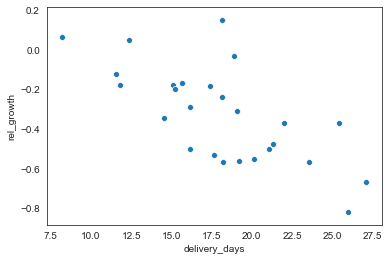

In [133]:
sns.scatterplot(data=corr,
                x="delivery_days",
                y="rel_growth");

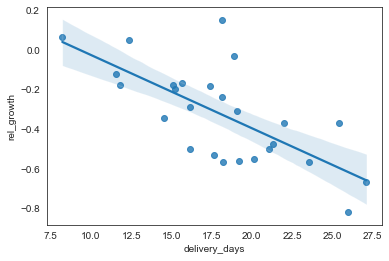

In [135]:
sns.regplot(data=corr,
            x="delivery_days",
            y="rel_growth");